# MSP Projekt 2
### Kryštof Paulík (xpauli08)
## Věrohodnost

[Celkem 4 body] V souboru Data_2024.xlsx (v listu Data_věrohodnost) máte zaznamenáno, jak dlouho po ukončení vzdělání pracují absolventi VUT ve „svém“ oboru (v letech). Někteří absolventi však po nějaké (zaznamenané) době přestali reagovat. U těchto absolventů je znám čas kdy přerušili kontakt (ale kdy ještě pracovali v oboru). Tato pozorování berte jako zprava cenzorovaná (jsou označena ve sloupečku „cesored“ jedničkou). Předpokládejte, že doba zaměstnání v oboru se řídí Weibullovým rozdělením pravděpodobnosti začínajícím v 0 (parametr prahu-threshold nastavte na 0).

1) Zapište zvolenou parametrizaci Weibullova rozdělení, logaritmickou-věrohodnostní funkci pro zadaná data a její parciální derivace podle parametrů (shape, scale).

### Hustota pravděpodobnosti a spolehlivostní funkce
(i - necenzurované hodnoty, j - cenzurované hodnoty)
$$
f(x) = \frac{k}{\lambda} \left( \frac{x}{\lambda} \right)^{k-1} e^{-\left( \frac{x}{\lambda} \right)^k}
$$

$$
S(x) = e^{-\left( \frac{x}{\lambda} \right)^k}
$$

### Logaritmická věrohodnostní funkce
$$
L(k, \lambda) = \prod_{\text{i}} \left[ \frac{k}{\lambda} \left( \frac{x_i}{\lambda} \right)^{k-1} e^{-\left( \frac{x_i}{\lambda} \right)^k} \right] 
\prod_{\text{j}} \left[ e^{-\left( \frac{x_j}{\lambda} \right)^k} \right]
$$

$$
\ell(k, \lambda) = \sum_{\text{i}} \left[ \ln\left( \frac{k}{\lambda} \right) + (k-1) \ln\left( \frac{x_i}{\lambda} \right) - \left( \frac{x_i}{\lambda} \right)^k \right]
+ \sum_{\text{j}} \left[ -\left( \frac{x_j}{\lambda} \right)^k \right]
$$

### Parciální derivace (shape, scale)
$$
\frac{\partial \ell}{\partial k} = \frac{n}{k} - n \ln(\lambda) + \sum_{\text{i}} \ln(x_i) - \sum_{\text{i}} \left( \frac{x_i}{\lambda} \right)^k \ln\left( \frac{x_i}{\lambda} \right)
- \sum_{\text{j}} \left( \frac{x_j}{\lambda} \right)^k \ln\left( \frac{x_j}{\lambda} \right)
$$

$$
\frac{\partial \ell}{\partial \lambda} = -\frac{n k}{\lambda} + k \sum_{\text{i}} \left( \frac{x_i}{\lambda} \right)^k \frac{1}{\lambda}
+ k \sum_{\text{j}} \left( \frac{x_j}{\lambda} \right)^k \frac{1}{\lambda}
$$

In [98]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import weibull_min, chi2

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import zscore

In [99]:
# Načtení dat
data = pd.read_excel('Data_2024.xlsx', sheet_name='Data_věrohodnost')

censored = data['censored'].values
work_time = data['doba práce v oboru [roky]'].values

2) Pomocí `scipy.optimize` nalezněte maximálně věrohodné odhady parametrů weibullova rozdělení

In [100]:
def weibull_log_likelihood(params):
    
    shape, scale = params
    if shape <= 0 or scale <= 0:
        return np.inf
    
    uncensored = (1 - censored)
    log_likelihood = (
        uncensored * weibull_min.logpdf(work_time, shape, scale=scale) +
        censored * weibull_min.logsf(work_time, shape, scale=scale)
    )
    return -np.sum(log_likelihood)

initial_params = [1.0, 1.0]
weibull_result = minimize(weibull_log_likelihood, initial_params, method='Nelder-Mead')

estimated_shape, estimated_scale = weibull_result.x
print(f'Odhad tvarového parametru (shape): {estimated_shape:.4f}')
print(f'Odhad měřítkového parametru (scale): {estimated_scale:.4f}')

Odhad tvarového parametru (shape): 6.1728
Odhad měřítkového parametru (scale): 7.4295


3) Pomocí věrohodnostního poměru otestujte hypotézu, že exponenciální rozdělení je postačujícím modelem zapsaných dat (Parametr tvaru = 1)

In [101]:
def exponential_log_likelihood(scale):
    if scale <= 0:
        return np.inf
    
    uncensored = (1 - censored)
    log_likelihood = (
        uncensored * weibull_min.logpdf(work_time, 1, scale=scale) +
        censored * weibull_min.logsf(work_time, 1, scale=scale)
    )
    return -np.sum(log_likelihood)

initial_scale = [1.0]
exp_result = minimize(exponential_log_likelihood, initial_scale, method='Nelder-Mead')

estimated_scale_exp = exp_result.x[0]
print(f'Odhad měřítkového parametru (scale) pro exponenciální rozdělení: {estimated_scale_exp:.4f}')
    
weibull_log_likelihood_value = -weibull_result.fun
exp_log_likelihood_value = -exp_result.fun

lambda_stat = 2 * (weibull_log_likelihood_value - exp_log_likelihood_value)
p_value = 1 - chi2.cdf(lambda_stat, df=1)

print(f"Log-věrohodnost pro Weibull: {weibull_log_likelihood_value:.4f}")
print(f"Log-věrohodnost pro exponenciální rozdělení: {exp_log_likelihood_value:.4f}")
print(f"Testové kritérium (lambda): {lambda_stat:.4f}")
print(f"P-hodnota: {p_value:.4f}")

if p_value < 0.05:
    print("Zamítáme nulovou hypotézu: Exponenciální rozdělení není postačující model.")
else:
    print("Nemůžeme zamítnout nulovou hypotézu: Exponenciální rozdělení je postačující model.")

Odhad měřítkového parametru (scale) pro exponenciální rozdělení: 9.0533
Log-věrohodnost pro Weibull: -450.1339
Log-věrohodnost pro exponenciální rozdělení: -746.3288
Testové kritérium (lambda): 592.3898
P-hodnota: 0.0000
Zamítáme nulovou hypotézu: Exponenciální rozdělení není postačující model.


4) Podle výsledku ze 3) použijte výsledné rozdělení pravděpodobnosti (s maximálně věrohodnými odhady jako parametry) a nalezněte bodové odhady pro střední dobu zaměstnání v oboru a 10% percentil zaměstnání v oboru (za jakou dobu odejde do jiného odboru 10 % absolventů).

In [102]:
mean_employment_duration = weibull_min.mean(estimated_shape, scale=estimated_scale)
print(f"Střední doba zaměstnání v oboru: {mean_employment_duration:.4f} let")

percentile_10 = weibull_min.ppf(0.10, estimated_shape, scale=estimated_scale)
print(f"10% percentil zaměstnání v oboru: {percentile_10:.4f} let")


Střední doba zaměstnání v oboru: 6.9032 let
10% percentil zaměstnání v oboru: 5.1598 let


## Regrese

[celkem 8 bodů] Disclaimer: data (včetně „příběhu“) jsou vygenerovaná a nemusí mít dobrý obraz v realitě. Berte, proto prosím výsledky z regrese s „rezervou“. Díky. Podařilo se Vám pomocí stroje času vrátit do doby „zlatého věku“ sociálních sítí a rozhodli jste se konkurovat Facebooku a Twitteru. V souboru Data_2024.xlsx (v listu Data_regrese) máte k dispozici záznamy od více než 500 uživatelů o rychlosti odezvy (sloupec ping [ms]) během používání Vaší aplikace. Ke každému zápisu máte navíc k dispozici údaje o počtu uživatelů (sloupec ActiveUsers) v daném okamžiku, o procentu uživatelů, kteří momentálně interagují s prezentovaným obsahem (sloupec InteractingPct), o procentu uživatelů, kteří jen tupě scrollují po Vaší obdobě timeline/twitterfeedu (sloupec ScrollingPct) a o operačním systému zařízení ze kterého se uživatel připojil (OSType).

##### 1) Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).
- Zapište rovnici Vašeho finálního modelu.

In [103]:
# Načtení dat a převedení kategorické proměnné OSType na 
data_2 = pd.read_excel("Data_2024.xlsx", sheet_name="Data_regrese")

data_2[["ActiveUsers", "Ping [ms]", "InteractingPct", "ScrollingPct"]] = data_2[["ActiveUsers", "Ping [ms]", "InteractingPct", "ScrollingPct"]].apply(pd.to_numeric)

# One-hot encoding - vyhodíme jeden sloupec, jelikož jej lze reprezentovat implicitně
# (pokud všechny ostatní OS budou 0, bude to znamenat, že uživatel má právě tento chybějící systém)
new_cols = pd.get_dummies(data_2['OSType'], drop_first=True).astype(float)
data_2 = data_2.drop('OSType', axis=1)
data_2 = data_2.join(new_cols)
print(data_2.head())

   ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]  MacOS  Windows  iOS
0         4113          0.8283        0.1717         47    0.0      0.0  1.0
1         7549          0.3461        0.6539         46    0.0      0.0  1.0
2         8855          0.2178        0.7822         55    0.0      1.0  0.0
3         8870          0.0794        0.9206         56    0.0      0.0  0.0
4         9559          0.7282        0.2718         76    1.0      0.0  0.0


In [104]:
corr = data_2.corr()
print(corr)

                ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]  \
ActiveUsers        1.000000        0.040275     -0.040275   0.693499   
InteractingPct     0.040275        1.000000     -1.000000   0.406957   
ScrollingPct      -0.040275       -1.000000      1.000000  -0.406957   
Ping [ms]          0.693499        0.406957     -0.406957   1.000000   
MacOS             -0.000136        0.086466     -0.086466   0.333107   
Windows            0.003135       -0.016964      0.016964   0.047783   
iOS               -0.063206       -0.062634      0.062634  -0.360491   

                   MacOS   Windows       iOS  
ActiveUsers    -0.000136  0.003135 -0.063206  
InteractingPct  0.086466 -0.016964 -0.062634  
ScrollingPct   -0.086466  0.016964  0.062634  
Ping [ms]       0.333107  0.047783 -0.360491  
MacOS           1.000000 -0.371550 -0.341322  
Windows        -0.371550  1.000000 -0.334506  
iOS            -0.341322 -0.334506  1.000000  


Z kódu výše je jasná korelace mezi `InteractingPct` a `ScrollingPct` (`InteractingPct = 1 - ScrollingPct`). Jednu z těchto hodnot tedy mohu zahodit:

In [105]:
data_2.drop(['ScrollingPct'], axis=1, inplace=True)

Definuji výchozí regresní model - plný kvadratický model, budu se snažit vyjádřit hodnotu `Ping [ms]`
Předtím je třeba vyřešit multikolinearitu, tu určím pomocí VIF.

In [106]:
formula = (
    # Lineární termy
    "Q('Ping [ms]') ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS "
    
    # Kvadratické termy
    "+ I(ActiveUsers**2) + I(InteractingPct**2) "
    
    # Interakce numerických proměnných
    "+ ActiveUsers:InteractingPct "
    
    # Interakce numerických a kategorických proměnných
    "+ ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS "
    "+ InteractingPct:MacOS + InteractingPct:Windows + InteractingPct:iOS"
)

model = smf.ols(formula, data_2)
result = model.fit()

# Z democvičení
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif_df = vif.to_frame()
vif_df.columns = ['VIF']

print(vif_df)

                                  VIF
Intercept                   79.081437
ActiveUsers                 30.108570
InteractingPct              26.021105
MacOS                       14.530955
Windows                     13.726080
iOS                         13.164975
I(ActiveUsers ** 2)         22.499134
I(InteractingPct ** 2)      16.060875
ActiveUsers:InteractingPct   8.851002
ActiveUsers:MacOS           10.454073
ActiveUsers:Windows         10.189613
ActiveUsers:iOS              9.061267
InteractingPct:MacOS         7.586537
InteractingPct:Windows       6.857633
InteractingPct:iOS           6.028016


Hodnoty `ActiveUsers` a `InteractingPct` normalizujeme na Z-score a podíváme se, jak se změní VIF.

In [107]:
data_2['ActiveUsers_z'] = (data_2['ActiveUsers'] - data_2['ActiveUsers'].mean()) / data_2['ActiveUsers'].std()
data_2['InteractingPct_z'] = (data_2['InteractingPct'] - data_2['InteractingPct'].mean()) / data_2['InteractingPct'].std()

formula = (
    # Lineární termy
    "Q('Ping [ms]') ~ ActiveUsers_z + InteractingPct_z + MacOS + Windows + iOS "
    
    # Kvadratické termy
    "+ I(ActiveUsers_z**2) + I(InteractingPct_z**2) "
    
    # Interakce numerických proměnných
    "+ ActiveUsers_z:InteractingPct_z "
    
    # Interakce numerických a kategorických proměnných
    "+ ActiveUsers_z:MacOS + ActiveUsers_z:Windows + ActiveUsers_z:iOS "
    "+ InteractingPct_z:MacOS + InteractingPct_z:Windows + InteractingPct_z:iOS"
)

model = smf.ols(formula, data_2)
result = model.fit()

# Z democvičení
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif_df = vif.to_frame()
vif_df.columns = ['VIF']

print(vif_df)

                                     VIF
Intercept                       6.781856
ActiveUsers_z                   4.918200
InteractingPct_z                4.737489
MacOS                           1.654677
Windows                         1.630480
iOS                             1.606613
I(ActiveUsers_z ** 2)           1.019635
I(InteractingPct_z ** 2)        1.032984
ActiveUsers_z:InteractingPct_z  1.041103
ActiveUsers_z:MacOS             2.335540
ActiveUsers_z:Windows           2.383411
ActiveUsers_z:iOS               2.247663
InteractingPct_z:MacOS          2.503341
InteractingPct_z:Windows        2.092440
InteractingPct_z:iOS            2.198356


Žádné VIF už nepřesahuje hodnotu 10 (toto jsem bral z democvičení). Nyní je ale nutné počítat s tím, že nová data bude také potřeba normalizovat na Z-score, aby model fungoval správně.

Teď bude následovat zpětná eliminace, budeme pokračovat tak dlouho, dokud každá z hodnot nebude pod hranicí 5%.

In [108]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('Ping [ms]')   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        17:09:04   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nejvyšší P-hodnota je `InteractingPct_z:IOS` => smažu ze vzorce a zopakuji:

In [109]:
formula = (
    # Lineární termy
    "Q('Ping [ms]') ~ ActiveUsers_z + InteractingPct_z + MacOS + Windows + iOS "
    
    # Kvadratické termy
    "+ I(ActiveUsers_z**2) + I(InteractingPct_z**2) "
    
    # Interakce numerických proměnných
    "+ ActiveUsers_z:InteractingPct_z "
    
    # Interakce numerických a kategorických proměnných
    "+ ActiveUsers_z:MacOS + ActiveUsers_z:Windows + ActiveUsers_z:iOS "
    "+ InteractingPct_z:MacOS + InteractingPct_z:Windows"
)

model = smf.ols(formula, data_2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('Ping [ms]')   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          3.58e-187
Time:                        17:09:04   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nejvyšší P-hodnota je `InteractingPct_z:Windows` => smažu ze vzorce a zopakuji:

In [110]:
formula = (
    # Lineární termy
    "Q('Ping [ms]') ~ ActiveUsers_z + InteractingPct_z + MacOS + Windows + iOS "
    
    # Kvadratické termy
    "+ I(ActiveUsers_z**2) + I(InteractingPct_z**2) "
    
    # Interakce numerických proměnných
    "+ ActiveUsers_z:InteractingPct_z "
    
    # Interakce numerických a kategorických proměnných
    "+ ActiveUsers_z:MacOS + ActiveUsers_z:Windows + ActiveUsers_z:iOS "
    "+ InteractingPct_z:MacOS"
)

model = smf.ols(formula, data_2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('Ping [ms]')   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          2.38e-188
Time:                        17:09:04   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nejvyšší P-hodnota je `InteractingPct_z:MacOS` => smažu ze vzorce a zopakuji:

In [111]:
formula = (
    # Lineární termy
    "Q('Ping [ms]') ~ ActiveUsers_z + InteractingPct_z + MacOS + Windows + iOS "
    
    # Kvadratické termy
    "+ I(ActiveUsers_z**2) + I(InteractingPct_z**2) "
    
    # Interakce numerických proměnných
    "+ ActiveUsers_z:InteractingPct_z "
    
    # Interakce numerických a kategorických proměnných
    "+ ActiveUsers_z:MacOS + ActiveUsers_z:Windows + ActiveUsers_z:iOS "
)

model = smf.ols(formula, data_2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('Ping [ms]')   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.57e-189
Time:                        17:09:04   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nejvyšší P-hodnota je `InteractingPct_z**2` => smažu ze vzorce a zopakuji:

In [112]:
formula = (
    # Lineární termy
    "Q('Ping [ms]') ~ ActiveUsers_z + InteractingPct_z + MacOS + Windows + iOS "
    
    # Kvadratické termy
    "+ I(ActiveUsers_z**2)  "
    
    # Interakce numerických proměnných
    "+ ActiveUsers_z:InteractingPct_z "
    
    # Interakce numerických a kategorických proměnných
    "+ ActiveUsers_z:MacOS + ActiveUsers_z:Windows + ActiveUsers_z:iOS "
)

model = smf.ols(formula, data_2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         Q('Ping [ms]')   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        17:09:04   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nyní již žádná hodnota nepřesahuje 0.05, tudíž jsme získali rovnici našeho finálního modelu:

$$
\begin{align*}
\text{Ping [ms]} = &51.0013 \\
&+ 10.0146 \cdot \text{ActiveUsers} \\
&+ 5.0399 \cdot \text{InteractingPct} \\
&+ 9.4142 \cdot \text{OSType\_MacOS} \\
&+ 3.8746 \cdot \text{OSType\_Windows} \\
&- 5.7581 \cdot \text{OSType\_iOS} \\
&- 2.7035 \cdot (\text{ActiveUsers})^2 \\
&- 2.3325 \cdot (\text{ActiveUsers} \cdot \text{InteractingPct}) \\
&+ 3.6179 \cdot (\text{ActiveUsers} \cdot \text{OSType\_MacOS}) \\
&- 1.8783 \cdot (\text{ActiveUsers} \cdot \text{OSType\_Windows}) \\
&- 2.6316 \cdot (\text{ActiveUsers} \cdot \text{OSType\_iOS})
\end{align*}
$$

- Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé
hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění,
vyřadit.

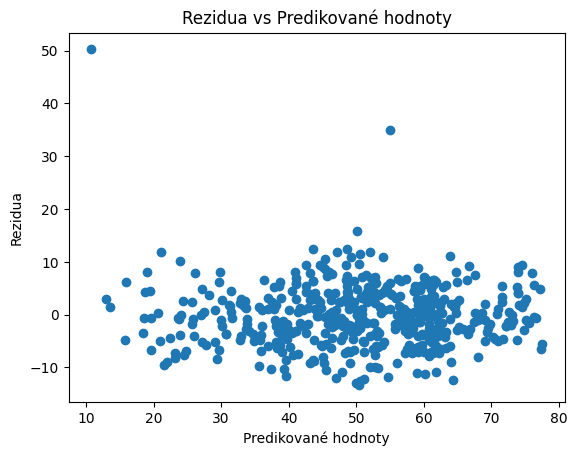

In [113]:
data_2['Predicted_Ping'] = result.predict(data_2)

# Z democvičení
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# Filtrace dat bez odlehlých hodnot
data_2 = data_2[abs(zscore(result.resid)) <= 3]

# Přepočítání modelu
model = smf.ols(formula, data_2)
result = model.fit()

Ve vykresleném grafu vidíme dvě výrazněji odlehlé hodnoty. Nemusely by být pro model problémem, ale zjistil jsem, že bez nich model vypadá lépe (viz poslední úloha). Odstraníme je pomocí scipy zscore a model přepočítáme.

- Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.

In [114]:
print("Střední hodnota původních dat:", data_2["Ping [ms]"].mean())
print("Střední hodnota predikcí modelu:", result.predict(data_2).mean())

Střední hodnota původních dat: 50.446
Střední hodnota predikcí modelu: 50.446000000000026


Náhodná veličina `Ping [ms]` má střední hodnotu, která odpovídá střední hodnotě modelu - splněno.

In [115]:
_, pval, _, f_pval = het_breuschpagan(result.resid, result.model.exog)
print(f"Cook-Weisbergův test: p-hodnota = {pval}")
if pval > 0.05:
    print("Konstatntní rozptyl.")
else:
    print("NE konstantní rozptyl.")

Cook-Weisbergův test: p-hodnota = 0.6356617661000774
Konstatntní rozptyl.


Náhodná veličina `Ping [ms]` má konstantní rozptyl - splněno.

In [116]:
dw = durbin_watson(result.resid)
print(f"Durbin-Watson test: d = {dw}")
if 1.5 < dw < 2.5:
    print("Rezidua nejsou korelovaná.")
else:
    print("Rezidua jsou korelovaná.")

Durbin-Watson test: d = 1.989961903427769
Rezidua nejsou korelovaná.


Náhodná veličina `Ping [ms]` není korelovaná - splněno.

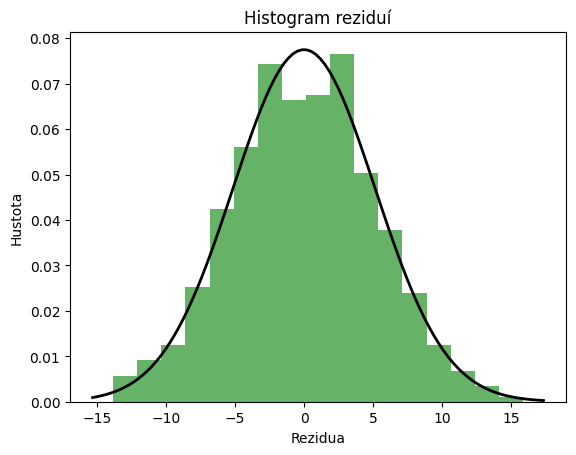

In [117]:
# Normalita pomocí grafu - kód z democvičení
plt.hist(result.resid, bins='auto', density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(result.resid), np.std(result.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")
plt.show()

Z grafu výše je patrné, že náhodná veličina `Ping [ms]` má normální rozdělení pravděpodobnosi - splněno.

V matici plánu by neměly existovat lineární závislosti mezi prediktory. Lineární závislost lze ověřit pomocí koeficientu VIF, který udává míru kolinearity, a který máme vypsaný výše. Hodnoty VIF jsou relativně nízké, lze tedy předpokládat, že kolinearita není významným problémem.

Dalším nástrojem pro odhalení potenciální lineární závislosti je analýza determinantu korelační matice. Pokud se determinant korelační matice blíží nule, může to naznačovat vysokou kolinearitu mezi některými prediktory, což znamená, že data vykazují lineární závislost. 

##### 2) Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější (největší) hodnotu (použijte model, nikoli samotná pozorování).

Nejproblematičtější nastavení parametrů je následující:

In [118]:
max_ping = result.predict().argmax()
print(data_2.iloc[max_ping])

ActiveUsers         9657.000000
InteractingPct         0.973000
Ping [ms]             72.000000
MacOS                  1.000000
Windows                0.000000
iOS                    0.000000
ActiveUsers_z          1.636436
InteractingPct_z       1.636444
Predicted_Ping        77.485765
Name: 10, dtype: float64


##### 3) Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

In [119]:
prediction = result.get_prediction({
	'ActiveUsers_z': data_2['ActiveUsers_z'].mean(),
	'InteractingPct_z': data_2['InteractingPct_z'].mean(),
	'MacOS': 0,
	'Windows': 1,
	'iOS': 0
})

mean_ping = prediction.predicted_mean
print("Odhadnutá odezva:")
print(mean_ping)

prediction = prediction.summary_frame(alpha=0.05)

ci_lower = prediction.iloc[0]['mean_ci_lower']
ci_upper = prediction.iloc[0]['mean_ci_upper']

print("\nKonfidenční interval:")
print("<" + str(ci_lower) + ", " + str(ci_upper) + ">")

pi_lower = prediction.iloc[0]['obs_ci_lower']
pi_upper = prediction.iloc[0]['obs_ci_upper']

print("\nPredikční interval:")
print("<" + str(pi_lower) + ", " + str(pi_upper) + ">")

Odhadnutá odezva:
[55.0026887]

Konfidenční interval:
<53.97214495766268, 56.03323244085544>

Predikční interval:
<44.72469273780256, 65.28068466071556>


##### 4) Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.

In [120]:
print(result.rsquared)

0.8773933243848616


Hodnota koeficientu determinace (R-squared) ukazuje, že model odpovídá přibližně na 88% původním datům, což je celkem slušné. Před odstraněním odlehlých hodnot to bylo okolo 84%. Příliš velká shoda by mohla (ale nemusela) být známkou toho, že model overfittuje. Regresní předpoklady jsou také splněny, jak jsme si ukázali výše. Model využívá smysluplné parametry. Je ale natrénován na normalizovaných datech (`ActiveUsers` a `InteractivePct`), je tedy potřeba tyto hodnoty u případných nových dat taktéž normalizovat.

Jediný problém, co mě napadá je, že model je vytvořen z velmi malého vzorku dat. V ideálním případě by pro trénování modelu měla být využita mnohem větší datová sada, než pouze 500 vzorků.